# 6. 核方法

In [2]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.kernel import (
    PolynomialKernel,
    RBF,
    GaussianProcessClassifier,
    GaussianProcessRegressor
)
def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

在第3、4章中，我们讨论了输入变量$ x $通过由可调节参数**向量$ w $控制**的映射$ y(x,w) $映射到输出$ y $的回归和分类的线性模型。在学习阶段，训练数据被同时用在参数向量的点估计和这个向量上的后验分布确定。**然后训练数据就被丢弃**，新输入的预测完全基于学习好的参数向量$ w $。这样的方法还被运用于像神经网络这样的非线性参数模型。

然而，有训练数据点或它的一个子集在预测阶段**仍然保留**并被使用的一类模式识别的技术。如：由每个“核”函数都以训练数据点为中心的线性组合构成的Parzen概率密度模型。类似地，在2.5.2节，我们介绍了一种被称为**最近邻的简单的分类方法**。这种方法把每个新的测试向量分配为训练数据集里距离最近的样本的标签。这些都是基于存储（memory-based）的方法的例子。基于存储的方法把整个训练数据存储起来，用来对未来的数据点进行预测。通常这种方法需要一个用来**定义输入空间任意两个向量之间的相似度的度量。这种方法通常“训练”速度很快，但是对测试数据点的预测速度很慢**。

许多线性参数模型可以被转化为一个**等价的预测的基础也是在训练数据点处计算的核函数（kernel function）的线性组合的“对偶表示”**。正如我们将看到的那样，对于基于固定非线性特征空间（feature space）映射$ \phi(x) $的模型来说，核函数由形式为
$ k(x,x') = \phi(x)^T\phi(x') \tag{6.1} $
的关系给出。根据这个定义，我们看到核函数关于它的参数是对称的，即$ k(x, x') = k(x', x) $。核的概念由Aizenman et al.(1964)引入模式识别领域。那篇文章介绍了势函数的方法。之所以被称为势函数，是因为它类似于静电学中的概念。虽然被忽视了很多年，但是Boser et al.(1992)在大边缘分类器的问题中把它重新引入到了机器学习领域。那篇文章提出了支持向量机（support vector machine）的方法。从那时起，这个话题在理论上和实用上都吸引了大家的兴趣。一个最重要的发展是把核方法进行了扩展，使其能处理符号化的物体，从而极大地扩展了这种方法能处理的问题的范围。

通过考虑式（6.1）中特征空间的恒等映射$ \phi(x) = x $，我们就得到了核函数的一个最简单的例子，此时$ k(x,x') = x^T x' $，我们把这称为线性核。

用特征空间的内积的方式表示核的概念使得我们通过核技巧（kernel trick），也被称为核替换（kernel substitution）能够对许多著名的算法进行有趣的扩展。**一般的思想是，如果我们有一个算法，它的输入向量$ x $只以标量积的形式出现，那么我们可以用一些其他的核来替换这个标量积**。例如，核替换方法可以用于主成分分析，从而产生了PCA的非线性变种（Scholkopf et al., 1998）。核替换的其他例子包括最近邻分类器和核Fisher判别函数（Mika et al., 1999; Roth and Steinhage, 2000; Baudat and Anouar, 2000）。

常用的核函数有各种不同的形式，我们会在本章中遇到若干个核函数的例子。许多核函数只是参数的差值的函数，即$ k(x,x') = k(x − x') $，，因为这样核函数对于输入空间的平移具有不变性，所以被称为静止核（stationary kernel）。另一种核函数是同质核（homogeneous kernel），也被称为径向基函数（radial basis function），它只依赖于参数之间的距离（通常是欧几里得距离）的大小，即$ k(x, x') = k(\Vert x − x' \Vert) $。

最近的关于核方法的教材有Scholkopf and Smola(2002),Herbrich(2002)和Shawe-Taylor and Cristianini(2004)。




# 6.1 对偶表示

许多回归和分类的线性模型的公式都可以使用核函数自然产生的对偶表示来重写。在我们下一章中讨论支持向量机的时候，这个概念十分重要。这里，我们考虑一个参数通过最小化形式为
$$
J(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{\boldsymbol{w}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{n}\right)-t_{n}\right\}^{2}+\frac{\lambda}{2} \boldsymbol{w}^{T} \boldsymbol{w}
\tag{6.2} $$
正则化的平方和误差函数来确定线性模型。其中$ \lambda \geq 0 $。如果我们令$ J(w) $关于$ w $的梯度等于0，那么我们看到$ w $的解是向量$ \phi(x_n) $的线性组合的形式，系数是$ w $的形式为
$ w = -\frac{1}{\lambda}\sum\limits_{n=1}^N\{w^T\phi(x_n) - t_n\}\phi(x_n) = \sum\limits_{n=1}^Na_n\phi(x_n) = \Phi^Ta \tag{6.3} $
的函数，其中$ \Phi $是设计矩阵，第$ n^{th} $行由$ \Phi(x_n)^T $给出，向量$ a = (a_1,...,a_N)^T $，且我们定义了
$ a_n = -\frac{1}{\lambda}{w^T\phi(x_n) - t_n} \tag{6.4} $
我们现在不直接对参数向量$ w $进行操作，而是使用参数向量$ a $重新整理最小平方算法，得到一个对偶表示（dual representation）。如果我们将$ w = \Phi^Ta $代入$ J(w) $，那么可以得到
$ J(a) = \frac{1}{2}a^T\Phi\Phi^T\Phi\Phi^Ta - a^T\Phi\Phi^Tt + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^T\Phi\Phi^Ta \tag{6.5} $
其中$ t = (t_1,...,t_N)^T $。我们现在定义Gram矩阵$ K = \Phi\Phi^T $，它是一个$ N \times N $的对称矩阵，元素为
$ K_{nm} = \phi(x_n)^T\phi(x_m) = k(x_n,x_m) \tag{6.6} $
其中引入了式（6.1）定义的核函数（kernel function）$ k(x,x') $。使用Gram矩阵，平方和误差函数可以写成
$ J(a) = \frac{1}{2}a^TKKa - a^TKt + \frac{1}{2}t^Tt + \frac{\lambda}{2}a^TKa \tag{6.7} $
令$ J(a) $关于$ a $的梯度为0，得到我们的解：
$ a = (K + \lambda I_N)^{-1}t \tag{6.8} $
如果我们把它代入线性回归模型中，对于新的输入$ x $，我们得到了下面预测
$ y(x) = w^T\phi(x) = a^T\Phi\phi(x) = k(x)^T(K + \lambda I_N)^{-1}t \tag{6.9} $
其中我们定义了向量$ k(x) $，它的元素为$ k_n(x) = k(x_n,x) $。因此我们看到对偶公式使得最小平方问题的解完全通过核函数$ k(x, x') $表示。**这被称为对偶公式，因为$ a $的解可以被表示为$ \phi(x) $的线性组合，从而我们可以使用参数向量$ w $恢复出原始的公式**。注意，在$ x $处的预测由训练集数据的目标值的线性组合给出。实际上，我们已经在3.3节中得到过这个结果，只不过记号稍微不同。

在对偶公式中，我们通过对一个$ N \times N $的矩阵求逆来确定参数向量$ a $，而在原始参数空间公式中，**我们要对一个$ M \times M $的矩阵求逆来确定$ w $。由于$ N $通常远大于$ M $，因此对偶公式似乎没有实际用处**。然而，正如我们将要看到的那样，对偶公式的优点是，它可以完全通过核函数$ k(x, x') $来表示。于是，我们可以直接针对核函数进行计算，**避免了显式地引入特征向量$ \phi(x) $**，这使得我们可以隐式地使用高维特征空间，甚至无限维特征空间。

基于Gram矩阵的对偶表示的存在是许多线性模型的性质，包括感知器。在6.4节，我们会研究回归的概率线性模型和高斯过程方法的对偶性。当我们在第7章讨论支持向量机的时候，对偶性也起着重要的作用。



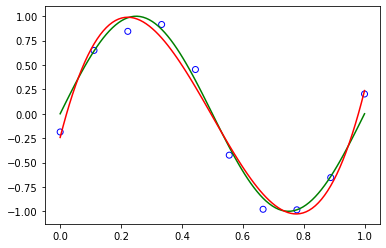

In [2]:
# 高斯过程回归
x_train, y_train = create_toy_data(sinusoidal, n=10, std=0.1)
x = np.linspace(0, 1, 100)

model = GaussianProcessRegressor(kernel=PolynomialKernel(3, 1.), beta=int(1e10))
model.fit(x_train, y_train)

y = model.predict(x)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
plt.show()

# 6.2 构造核

为了利用核替换，我们需要能够构造有效的核函数。**一种方法是选择一个特征空间映射$ \phi(x) $，然后使用这个映射寻找对应的核**，如图6.1所示。
 
图 6.1 从对应的基函数集合构建核函数的例子

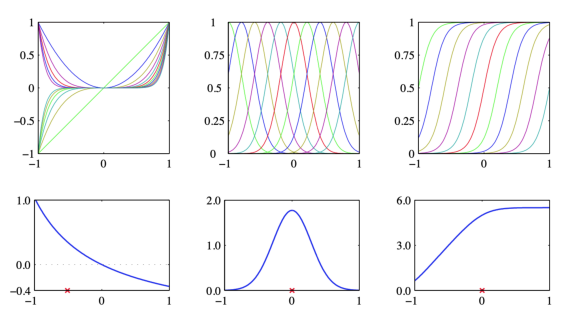

In [3]:
# 图6.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.1.png')
plt.axis('off')
ax.imshow(d)


这里，一维空间的核函数被定义为
$ k(x,x') = \phi(x)^T\phi(x') = \sum\limits_{i=1}^M\phi_i(x)\phi_i(x') \tag{6.10} $
其中$ \phi_i(x) $是基函数。

**另一种方法是直接构造核函数**。在这种情况下，**我们必须确保我们核函数是有效的，即它对应于某个（可能是无穷维）特征空间的标量积**。作为一个简单的例子，考虑下面的核函数
$ k(x,z) = (x^T,z)^2 \tag{6.11} $
如果我们取二维输入空间$ x=(x_1,x_2) $的特殊情况，那么我们可以展开这一项得到的非线性特征映射：
$ \begin{eqnarray} k(x,z) &=& (x^Tz)^2 = (x_1z_1 + x_2z_2)^2 \\&=& x_1^2z_1^2 + 2x_1z_1x_2z_2 + x_2^2z_2^2 \\&=& (x_1^2,\sqrt{2}x_1x_2,x_2^2)(z_1^2,\sqrt{2}z_1z_2,z_2^2)^T\\ &=& \phi(x)^T\phi(z) \tag{6.12} \end{eqnarray} $
我们看到特征映射的形式为$ \phi(x)=(x_1^2, \sqrt{2}x_1x_2, x_2^2)^T $，因此这个特征映射由所有具有具体系数的二阶项组成。

但是，更一般地，我们需要找到一种更简单的方法检验一个函数是否是一个有效的核函数，而不需要显示的构造函数$ \phi(x) $。**核函数$ k(x,x') $是一个有效的核函数的充分必要条件是Gram矩阵（元素由$ k(x_n, x_m) $给出）在所有的集合$ {x_n} $的选择下都是半正定的**（Shawe-Taylor and Cristianini, 2004）。注意，一个半正定的矩阵与元素全部非负的矩阵不同。

构造新的核函数的一个强大的方法是使用简单的核函数作为基本的模块来构造。可以使用下面的性质来完成这件事：

### 构造新核的技术

给定有效的核$ k_1(x,x') $和$ k_2(x, x') $，下面的新核也是有效的
$ \begin{eqnarray} k(x,x') &=& ck_1(x,x') \tag{6.13} \end{eqnarray}$ 
$\begin{eqnarray}\ k(x,x') &=& f(x)k_1(x,x')f(x') \tag{6.14} \end{eqnarray}$ 
$\begin{eqnarray}\ k(x,x') &=& q(k_1(x,x')) \tag{6.15}\end{eqnarray}$
$\begin{eqnarray} \ k(x,x') &=& exp(k_1(x,x')) \tag{6.16} \end{eqnarray}$
$\begin{eqnarray}\ k(x,x') &=& k_1(x,x') + k_2(x,x') \tag{6.17} \end{eqnarray}$
$\begin{eqnarray}\ k(x,x') &=& k_1(x,x')k_2(x,x') \tag{6.18} \end{eqnarray}$ 
$\begin{eqnarray}\ k(x,x') &=& k_3(\phi(x),\phi(x')) \tag{6.19}\end{eqnarray}$
$\begin{eqnarray} \ k(x,x') &=& x^TAx' \tag{6.20} \end{eqnarray}$
$\begin{eqnarray}\ k(x,x') &=& k_a(x_a,x_a') + k_b(x_b,x_b') \tag{6.21} \end{eqnarray}$
$\begin{eqnarray}\ k(x,x') &=& k_a(x_a,x_a')k_b(x_b,x_b') \tag{6.22} \end{eqnarray} $


其中$ c > 0 $是一个常数，$ f(.) $是任意函数，$ q(.) $是一个系数非负的多项式，$ \phi(x) $是一个从$ x $到$ \mathbb{R}^M $的函数，$ k_3(., .) $是$ \mathbb{R}^M $中的一个有效的核，$ A $是一个对称半正定矩阵，$ x_a, x_b $是变量（未必不相交），且$ x = (x_a, x_b) $。$ k_a,k_b $是各自空间的有效的核函数。

知道了这些性质后，我们可以开始构造适用于具体应用的更复杂的核函数了。我们要求核$ k(x,x') $是对称的半正定的，且它表示面向具体应用中$ x,x' $之间的适当形式的相似性。这里，我们考虑核函数的几个常见的例子。关于“**核工程**”的一个更加广泛的讨论，可以参考Shawe-Taylor and Cristianini(2004)。

我们看到简单的多项式核$ k(x,x') = (x^Tx')^2 $值包含二次项。如果我们考虑稍微一般的核$ k(x, x') = (x^Tx' + c)^2 $，其中$ c > 0 $，那么对应的特征映射$ \phi(x) $就会包含常数、线性项和二阶项。同样的$ k(x, x') = (x^Tx')^M $包含所有$ M $阶的单项式。如：如果$ x,x' $是两张图片，那么这个核表示第一张图片中$ M $个像素和第二张图片中$ M $个像素的所有可能的乘积的一个特定的加权和。这个可以类似地进行推广，使其包含所有次数最高为$ M $的项。推广的方式为$k(x, x') = (x^Tx' + c)^M$，其中c > 0。使用式（6.17）和式（6.18）给出的将核函数进行组合的方法，我们看到这些都是有效的核函数。

另一个经常使用的核函数的形式为
$$
k\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\exp \left(-\frac{\left\|\boldsymbol{x}-\boldsymbol{x}^{\prime}\right\|^{2}}{2 \sigma^{2}}\right)
 \tag{6.23} $$
这经常被称为高斯核。但是注意，在我们现在的讨论中，它不表示概率密度，因此标准化系数被省略了。由于它平方项展开：
$$ \Vert x - x'\Vert^2 = x^Tx + (x')^Tx' - 2x^Tx' \tag{6.24} $$
从而
$$ k(x,x') = exp\left(-\frac{x^Tx}{2\sigma^2}\right)exp\left(\frac{x^Tx'}{\sigma^2}\right)exp\left(-\frac{(x')^Tx'}{2\sigma^2}\right) \tag{6.25} $$
然后使用式（6.14）（6.16）以及线性核$ k(x, x') = x^Tx' $的有效性，所以这也是一个有效的核。注意，**对应于高斯核的特征向量有无穷维的**。

高斯核并不局限于使用欧几里得距离。如果我们使用式（6.24）中的核替换，将$ x^Tx' $替换为一个非线性核$ \kappa(x, x') $，得到
$$
k\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\exp \left\{-\frac{1}{2 \sigma^{2}}\left(\kappa(\boldsymbol{x}, \boldsymbol{x})+\kappa\left(\boldsymbol{x}^{\prime}, \boldsymbol{x}^{\prime}\right)-2 \kappa\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)\right)\right\}
 \tag{6.26} $$


核观点的一个重要的贡献是可以扩展到符号化的输入，而不是简单的实数向量。核函数可以定义在多种对象上，如图片、集合、字符串、文本文档。考虑一个固定的集合，定义一个非向量空间，这个空间由这个集合的所有可能的子集构成。如果$ A_1, A_2 $是两个这样的子集，那么核的一个简单的选择可以是
$$ k(A_1,A_2) = 2^{\vert A_1 \cap A_2 \vert} \tag{6.27} $$
其中$ A_1 \cap A_2 $表示$ A_1, A_2 $的交集，$ \vert A \vert $表示$ A $元素的数量。**因为可以证明它对应于一个特征空间中的一个内积，所以这是一个有效的核。**

构造核的另一个强大的方法是从一个概率生成式模型开始构造（Haussler, 1999），这使得我们可以在一个判别式的框架中使用生成式模型。**生成式模型可以自然地处理缺失数据，并且在隐马尔科夫模型的情况下，可以处理长度变化的序列。但是，判别式模型在判别式的任务中通常会比生成式模型的表现更好。**于是，将这两种方法结合吸引了一些人的兴趣（Lasserre et al., 2006）。一种将二者结合的方法是使用一个生成式模型定义一个核，然后在判别式方法中使用这个核。

给定一个生成式模型$ p(x) $，我们可以定义一个核
$$ k(x,x') = p(x)p(x') \tag{6.28} $$
很明显，我们可以把它看成由映射$ p(x) $定义的一维特征空间中的一个内积，所以这是一个有效的核。它表明，如果两个输入$ x, x' $都具有较高的概率，那么它们就是相似的。我们可以使用式（6.13）和（6.17）再通过带有正权值系数$ p(i) $，形式为
$$ k(x,x') = \sum\limits_ip(x|i)p(x'|i)p(i) \tag{6.29} $$
的不同概率分布的乘积的加和来扩展这类核。如果不考虑一个整体的乘法常数，这个核就等价于一个混合概率密度，它可以分解成各个分量概率密度，下标$ i $扮演着“潜在”变量的角色。如果两个输入$ x, x' $在一大类的不同分量下都有较大的概率，那么这两个输入将会使核函数输出较大的值，因此就表现出相似性。在无限求和的极限情况下，我们也可以考虑
$$ k(x,x') = \int p(x|z)p(x'|z)p(z)dz \tag{6.30} $$
这样形式的核函数，其中$ z $是一个连续潜在变量。

现在假设我们的数据由长度为$ L $的有序序列组成，即一个观测为$ X = {x_1,...,x_L} $。对于这种序列，一个流行的生成式模型是隐马尔科夫模型，它把概率$ p(X) $表示为对应的隐含状态序列$ Z = {z_1,...,z_L} $上的积分或求和。我们可以通过扩展混合表示(6.29)，得到
$$ k(X,X') = \sum\limits_z p(X|Z)p(X'|Z)p(Z) \tag{6.31} $$
从而两个观测序列都通过相同的隐含序列$ Z $生成，来定义的核函数来度量两个序列$ X, X' $的相似度。这个模型很容易扩展，使其能够比较不同长度的序列。

另一个使用生成式模型定义核函数的方法被称为Fisher核（Jaakkola and Haussler, 1999）。 考虑一个参数生成式模型$ p(x|\theta) $，其中$ \theta $表示参数的向量。目标是找到一个核，度量这个生成式模型的两个输入变量$ x,x' $之间的相似性。Jaakkola and Haussler(1999)考虑关于$ \theta $的梯度，它定义了一个维度与$ \theta $的维度相同的“特征”空间的一个向量。特别地，它们考虑Fisher得分
$$
g(\boldsymbol{\theta}, \boldsymbol{x})=\nabla_{\boldsymbol{\theta}} \ln p(\boldsymbol{x} \mid \boldsymbol{\theta})
\tag{6.32} $$
根据Fisher得分，Fisher核被定义为
$$ k(x,x') = g(\theta,x)^TF^{-1}g(\theta,x') \tag{6.33} $$
这里，$ F $是Fisher信息矩阵（Fisher information matrix），定义为
$$ F = \mathbb{E}_x[g(\theta,x)g(\theta,x)^T] \tag{6.34} $$
其中，期望是在概率分布$ p(x|\theta) $下关于$ x $的期望。这样定义的动机可以从信息几何（information geometry）的角度看出来（Amari, 1998），它考虑了模型参数空间的微分几何。这里，我们注意到，Fisher信息矩阵的存在使得这个核在密度模型的非线性重参数化$ \theta \to \psi(\theta) $下具有不变性。

在实际应用中，通常计算Fisher信息矩阵是不可行的。一种方法是把Fisher信息的定义中的期望替换为样本均值，得到
$$ F \simeq \frac{1}{N}\sum\limits_{n=1}^Ng(\theta,x_n)g(\theta,x_n)^T \tag{6.35} $$
这是Fisher得分的协方差矩阵，因此Fisher核对应于这些分数的一个漂白。更简单地，我们可以省略Fisher信息矩阵，使用非不变核
$$ k(x,x') = g(\theta,x)^Tg(\theta,x') \tag{6.36} $$
Hofmann(2000)给出了Fisher核在文档抽取上的一个应用。


核函数的最后的一个例子定义为
$$ k(x,x') = \tanh(ax^Tx' + b) \tag{6.37} $$
是sigmoid核，它的Gram矩阵通常不是半正定的。但是这种核在实际应用中也可以使用（Vapnik, 1995），可能是因为它赋予核展开（如支持向量机）一个与神经网络模型的表面的相似性。正如我们将看到的那样，在基函数有无穷多的极限情况下，一个具有恰当先验的贝叶斯神经网络将会变为高斯过程，因此这就提供了神经网络与核方法之间的一个更深层的联系。

# 6.3 径向基函数网络

在第3章，我们讨论了基于固定基函数的线性组合的回归模型，但是我们没有详细讨论可以取哪种形式的基函数。一种广泛使用的基函数是径向基函数（radial basis functions）。径向基函数中，每一个基函数只依赖于样本和中心$ \mu_j $之间的径向距离（通常是欧几里得距离），即$ \phi_j(x) = h(\Vert x − \mu_j \Vert) $。
历史上，径向基函数被用来进行精确的函数插值（Powell, 1987）。给定一组输入向量$ {x_1,...,x_N} $以及对应的目标值$ {t_1,...,t_N} $，目标是找到一个光滑的函数$ f(x) $。将$ f(x) $表示为径向基 函数的线性组合，每个径向基函数都以数据点为中心，即
$ f(x) = \sum\limits_{n=1}^Nw_nh(\Vert x-x_n \Vert) \tag{6.38} $
系数$ {w_n} $的值由最小平方方法求出。并且，由于具有与系数数量相同的限制条件，因此结果是一个能够精确拟合每个目标值的函数，即对于$ n=1,...,N $，都有$ f(x_n) = t_n $。但是，在模式识别应用中，目标值通常带有噪声，所以精确插值对应于一个过拟合的解，所以这不是我们想要的。
对径向基函数的展开来自正则化理论（Poggio and Girosi, 1990; Bishop, 1995a）。对于一个使用微分操作定义的带有正则化项的平方和误差函数，最优解可以通过对算符的Green函数（类似 于离散矩阵的特征向量）进行展开，每个数据点有一个基函数。如果微分算符是各向同性的，那么Green函数只依赖于与对应的数据点的径向距离。由于正则化项的存在，因此解不再精确地对训练数据进行插值。
径向基函数的另一个研究动机来源于输入变量（而不是目标变量）具有噪声时的插值问题（Webb, 1994; Bishop, 1995a）。如果输入变量$ x $上的噪声由一个服从分布$ v(\xi) $的变量$ \xi $描述，那么平方和误差函数就变成了
$ E = \frac{1}{2}\sum\limits_{n=1}^N\int {y(x_n + \xi) - t_n}^2v(\xi)d\xi \tag{6.39} $
使用变分法，我们可以关于函数$ y(x) $进行最优化，得到
$ y(x) = \sum\limits_{n=1}^N t_nh(x-x_n) \tag{6.40} $
其中基函数为
$ h(x-x_n) = \frac{v(x-x_n)}{\sum\limits_{n=1}^Nv(x-x_n)} \tag{6.41} $
我们看到这是一个以每个数据点为中心的基函数。这被称为Nadaraya-Watson模型。在6.3.1节， 我们会从一个不同的角度再次推导出这个模型。如果噪声分布$ v(\xi) $是各向同性的，即它只是$ \Vert \xi \Vert $的一个函数，那么基函数就是径向的。
注意，基函数(6.41)是标准化的，即对于所有的$ x $值都有$ \sum_n h(x − x_n) = 1 $。这种标准化的效果如图6.2所示。
 
图 6.2 左图给出了一组高斯基函数的图像，右图给出了对应的归一化的基函数的图像。


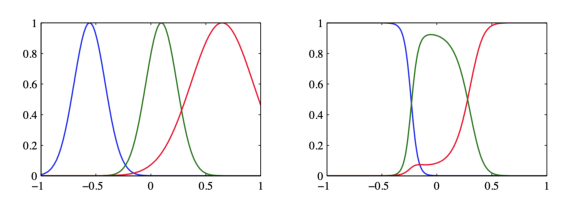

In [5]:
# 图6.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.2.png')
plt.axis('off')
ax.imshow(d)

有时在实际应用中会用到标注啊，因为它避免了输入空间中存在所有的基函数全部取较小值的区域，这种区域会导致在这些区域的预测值过小，或完全由基参数控制。
另一个展开归一化径向基函数的情况是把核密度估计应用到回归问题中，正如我们将在6.3.1 节讨论的那样。
由于每一个数据点都关联了一个基函数，因此当对于新的数据点进行预测时，对应的模型的计算开销会非常大。因此一些新的模型被提出来（Broomhead and Lowe, 1988; Moody and Darken, 1989; Poggio and Girosi, 1990），这些模型仍然对径向基函数进行展开，但是基函数的数量$ M $要小于数据点的数量$ N $。通常，基函数的数量，以及它们的中心$ \mu_i $，都只是基于输入数据$ {x_n} $自身来确定。然后基函数被固定下来，系数$ {w_i} $由最小平方方法通过解线性方程的方式确定，正如3.1.1节讨论的那样。
选择基函数中心的一种最简单的方法是使用数据点的一个随机选择的子集。一个更加系统化的方法被称为正交最小平方（Chen et al., 1991）。这是一个顺序选择的过程，在每一个步骤中，被选择作为基函数的下一个数据点对应于能够最大程度减小平方和误差的数据点。展开系数值的确定是算法的一部分。还可以使用聚类算法（如$ K $均值算法），这时得到的一组基函数中心不再与训练数据点重合。




## 6.3.1 Nadarya-Waston模型

在3.3.3节中，我们看到线性回归模型对新输入$ x $的预测是系数由满足加和限制“等价核”（3.62）给出的训练数据集的目标值的线性组合。
我们可以从核密度估计开始，以一个不同的角度研究核回归模型（3.61）。假设我们有一个训练集$ {x_n, t_n} $，我们使用Parzen密度估计来对联合分布$ p(x, t) $进行建模，即
$ p(x,t) = \frac{1}{N}\sum\limits_{n=1}^Nf(x-x_n,t-t_n) \tag{6.42} $
其中$ f(x,t) $是分量密度函数，每个数据点都有一个这种以数据点为中心的分量。我们现在要找到回归函数$ y(x) $的表达式，对应于以输入变量为条件的目标变量的条件均值，它的表达式为
$ \begin{eqnarray} y(x) &=& \mathbb{E}[t|x] = \int_{-\infty}^\infty tp(t|x)dt \ &=& \frac{\int tp(x,t)dt}{\int p(x,t)dt} \ &=& \frac{\sum\limits_n\int tf(x-x_n,t-t_n)dt}{\sum\limits_m\int f(x-x_m,t-t_m)dt} \tag{6.43} \end{eqnarray} $
简单起见，现在，我们假设量的密度函数的均值为零，即
$ \int_{-\infty}^\infty f(x,t)tdt = 0 \tag{6.44} $
对所有$ x $都成立。使用一个简单的变量替换，得到
$ \begin{eqnarray} y(x) &=& \frac{\sum\limits_ng(x-x_n)t_n}{\sum\limits_mg(x-x_m)} \ &=& \sum\limits_nk(x,x_n)t_n \tag{6.45} \end{eqnarray} $
其中$ n,m = 1,...,N $，且核函数$ k(x,x_n) $由
$ k(x,x_n) = \frac{g(x-x_n)}{\sum\limits_mg(x-x_m)} \tag{6.46} $
我们还定义了
$ g(x) = \int_{-\infty}^\infty f(x,t)dt \tag{6.47} $
式（6.45）被称为Nadaraya-Watson模型或核回归（kernel regression）（Nadaraya, 1964; Watson, 1964）。对于局部核函数，它具有给距离$ x $较近的数据点$ x_n $较高的权重的性质。注意，核（6.46）满足加和限制：
$ \sum\limits_{n=1}^Nk(x,x_n) = 1 $
实际上，这个模型不仅定义的条件期望，还定义了整个条件概率分布
$ p(t|x) = \frac{p(t,x)}{\int p(t,x)dt} = \frac{\sum\limits_nf(x-x_n,t-t_n)}{\sum\limits_m\int f(x-x_m,t-t_m)dt} \tag{6.48} $
从中我们也可以计算其它期望。
为了举例说明，我们考虑一元输入变量$ x $的情形，其中$ f(x,t) $由变量$ z = (x, t) $上的一个零均值各向同性的高斯分布给出，方差为$ \sigma^2 $。对应的条件分布（6.48）由高斯混合模型给出。图6.3展示了在人工生成的正弦曲线数据集下，这个条件分布的情况以及它的均值。
 
图 6.3 使用各向同性的高斯核的Nadaraya-Watson核回归模型的说明。数据集为正弦数据集。原始的正弦函数由绿色曲线表示，数据点由蓝色的点表示，每个数据点是一个各向同性的高斯核的中心。得到的回归函数，由条件均值给出，用红线表示。同时给出的还有条件概率分布$ p(t|x) $的两个标准差的区域，用红色阴影表示。在每个数据点周围的蓝色椭圆给出了对应的核的一个标准差轮廓线。由于水平轴和垂直轴的标度不同，这些轮廓线似乎不是圆形的。

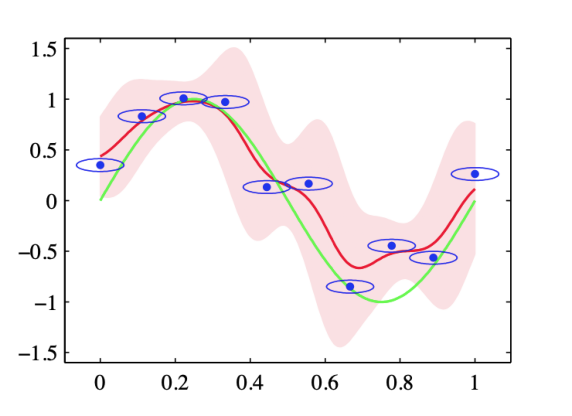

In [6]:
# 图6.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.3.png')
plt.axis('off')
ax.imshow(d)

这个模型的一个直接的推广是允许形式更灵活的高斯分布作为其分量，如让输入和目标值具有不同方差。更一般地，我们可以使用第9章讨论的方法训练（Ghahramani and Jordan, 1994）的高斯混合模型对联合分布$ p(t,x) $建模，然后找到对应的条件概率分布$ p(t|x) $。在后一种情况中，模型不再由训练数据点处的核函数表示，但是混合模型中分量的个数会小于训练数据点的个数，从而使得生成的模型对于测试数据点能够更快地计算。为了能够生成一个预测速度较快的模型，我们可以接受训练阶段的计算开销。


# 6.4 高斯过程

在6.1节，通过将对偶性的概念应用于回归的非概率模型，我们引出了核的概念。这里，我们把核的角色推广到概率判别式模型中，引出了高斯过程的框架。于是，我们会看到在贝叶斯方法中，核是如何自然地被引入的。
在第3章，我们考虑了形式为$ y(x, w) = w^T\phi(x) $线性回归模型，其中$ w $是一个参数向量，$ \phi(x) $是一个与输入向量$ x $相关的固定非线性基函数向量。我们证明了，$ w $上的先验分布会产生函数$ y(x, w) $上的一个对应的先验分布。给定一个训练数据集，我们计算$ w $上的后验概率分布，从而就得到和回归函数的对应的后验概率分布。回归函数反过来（叠加上噪声）表示了对新输入向量x的一个预测分布$ p(t|x) $。
在高斯过程的观点中，我们抛弃参数模型，直接定义函数上的先验概率分布。乍一看来，在函数组成的不可数的无穷空间中对概率分布进行计算似乎很困难。但是，正如我们将看到的那样，对于一个有限的训练数据集，我们只需要考虑训练数据集和测试数据集的输入$ x_n $处的函数值即可，因此在实际应用中我们可以在有限的空间中进行计算。
等价于高斯过程的模型在许多不同领域被广泛研究。例如，在统计地质学中文献中，高斯过程回归被称为kriging（Cressie, 1993）。类似地，ARMA（自动回归移动平均autoregressive moving average）模型、Kalman滤波以及径向基函数网络都可以被看成高斯过程模型的形式。关于从机器学习的角度对高斯过程的回顾，可以参考MacKay(1998)、Williams(1999)和MacKay(2003)。Rasmussen(1996)给出了一个不同的方法来对各个高斯过程模型进行对比。有关高斯过程的最近的教科书，可以参考Rasmussen and Williams(2006)。



## 6.4.1 重新考虑线性回归问题

为了引出高斯过程的观点，让我们回到线性回归的例子中，通过对函数$ y(x, w) $的计算，重新推导出预测分布。来给出高斯过程的一个具体的例子。
考虑一个模型$ M $，它被定义为由向量$ \phi(x) $的元素给出的$ M $个固定基函数的线性组合，即
$ y(x) = w^T\phi(x) \tag{6.49} $
其中$ x $是输入向量，$ w $是$ M $维权向量。现在，考虑$ w $上的一个先验概率分布，这个分布是一个各向同性的高斯分布，形式为
$ p(w) = \mathcal{N}(w|0,\alpha^{-1}I) \tag{6.50} $
它由一个表示分布精度（方差的逆）的超参数$ \alpha $控制。对于任意给定的$ w $，式（6.49）定义了$ x $的一个特定函数。于是，式（6.50）定义的$ w $上的概率分布就产生了一个函数$ y(x) $上的一个概率分布。在实际应用中，我们希望计算这个函数在某个具体的$ x $处的函数值，例如在训练数据点$ x_1,...,x_N $处的函数值。于是我们感兴趣的是函数值$ y(x_1),...,y(x_N) $的概率分布。我们把函数值的集合记作向量，它的元素为$ y_n = y(x_n) $，其中$ n = 1,...,N $。根据式（6.49）这个向量等于
$ y = \Phi w \tag{6.51} $
其中$ \Phi $是设计矩阵，元素为$ \Phi_{nk} = \phi_k(x_n) $。首先，我们注意到由$ w $的元素给出的服从高斯分布的变量的线性组合，因此它本身是服从高斯分布。 于是，我们只需要找到它的均值和方差找到的概率分布，就找到$ y $的概率分布。根据公式（6.50），均值和方差为
$ \begin{eqnarray} \mathbb{E}[y] &=& \Phi\mathbb{E}[w] = 0 \tag{6.52} \\ cov[y] &=& \mathbb{E}[yy^T] = \Phi\mathbb{E}[ww^T]\Phi^T = \frac{1}{\alpha}\Phi\Phi^T = K \tag{6.53} \end{eqnarray} $
其中$ K $是元素为
$ K_{nm} = k(x_n,x_m) = \frac{1}{\alpha}\phi(x_n)^T\phi(x_m) \tag{6.54} $
的Gram矩阵。其中$ k(x,x') $是核函数。
这个模型给我们提供了高斯过程的一个具体的例子。通常来说，高斯过程被定义为函数$ y(x) $上的一个概率分布，使得在任意点集$ x_1,...,x_N $处计算的$ y(x) $的值的集合联合起来服从高斯分布。在输入向量$ x $是二维的情况下，这也可以被称为高斯随机场（Gaussian random field）。更一般地，可以用一种合理的方式为$ y(x_1),...,y(x_N) $赋予一个联合的概率分布，来确定一个随机过程（stochastic process）$ y(x) $。
高斯随机过程的一个关键点是$ N $个变量$ y_1,...,y_N $上的联合概率分布完全由二阶统计（即均值和协方差）确定。在大部分应用中，我们关于$ y(x) $的均值没有任何先验的知识，因此根据对称性，我们令其等于零。这等价于基函数的观点中，令权值$ p(w|\alpha) $的先验概率分布的均值等于0。之后，高斯过程的确定通过给定两个$ x $处的函数值$ y(x) $的协方差来完成。这个协方差由核函数确定
$ \mathbb{E}[y(x_n)y(x_m)] = k(x_n,x_m) \tag{6.55} $
对于由式（6.49）定义的带有权值先验（6.50）的线性回归模型来说，核函数为（6.54）。
我们也可以直接定义核函数，而不是间接地通过选择基函数。图6.4给出了两个不同的核函数的由高斯过程产生的函数的样本。
 
图 6.4 左图为“高斯”核的高斯过程的样本，右图为指数核的高斯过程的样本


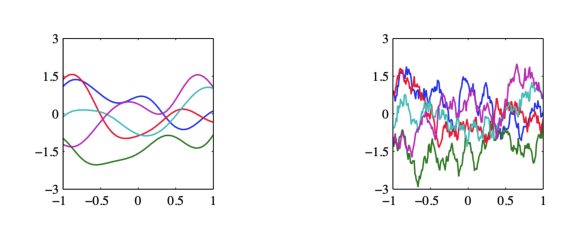

In [12]:
# 图6.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.4.png')
plt.axis('off')
ax.imshow(d)

第一个核函数是式（6.23）定义的高斯核，第二个核函数是定义为
$ k(x,x') = exp(-\theta\vert x - x' \vert) \tag{6.56} $
的指数核。它对应于最开始由Uhlenbeck and Ornstein(1993)提出的，用来描述布朗运动的Ornstein-Uhlenbeck过程。

## 6.4.2 用于回归的高斯过程

为了把高斯过程模型应用于回归问题，我们需要考虑观测目标值的形式为
$ t_n = y_n + \epsilon_n \tag{6.57} $
的噪声，其中$ y_n = y(x_n) $，$ \epsilon_n $是一个随机噪声变量，它的值对于每个观测$ n $是独立的。这里，我们需要考虑服从高斯分布的噪声过程，即
$ p(t_n|y_n) = \mathcal{N}(t_n|y_n,\beta^{-1}) \tag{6.58} $
其中$ \beta $是一个表示噪声的精度的超参数。由于噪声对于每个数据点是独立的，所以以$ y = (y_1,...,y_N)^T $为条件，目标值$ t = (t_1,...,t_N)^T $的联合概率分布是一个形式为
$ p(t|y) = \mathcal{N}(t|y,\beta^{-1}I_N) \tag{6.59} $
的各向同性的高斯分布，其中$ I_N $表示一个$ N \times N $的单位矩阵。根据高斯过程的定义，边缘概率分布$ p(y) $是一个高斯分布，均值为0，协方差由Gram矩阵$ K $定义，即
$ p(y) = \mathcal{N}(y|0,K) \tag{6.60} $
确定$ K $的核函数通常通常选择那些具有对于相似的点$ x_n $和$ x_m $，对应的值$ y(x_n),y(x_m) $的相关性要大于不相似的点的性质的函数。这里，相似性的概念取决于实际应用。
为了找到以输入值$ x1,...,x_N $为条件的边缘概率分布$ p(t) $，我们需要对$ y $积分。可以通过使用2.3.3节的线性高斯模型的结果来完成。使用式（2.115），我们看到的边缘概率分布为
$ p(t) = \int p(t|y)p(y)dy = \mathcal{N}(t|O,C) \tag{6.61} $
其中协方差矩阵$ C $的元素为：
$ C(x_n,x_m) = k(x_n,x_m) + \beta^{-1}\delta_{nm} \tag{6.62} $
这个结果反映了下面的事实：两个随机的高斯分布（即与$ y(x) $相关的和与$ \epsilon $相关的高斯分布）是独立的，因此它们的协方差可以简单地相加。
对于高斯过程回归，一个广泛使用的核函数的形式为指数项的二次型加上常数和线性项，即
$$
k\left(\boldsymbol{x}_{n}, \boldsymbol{x}_{m}\right)=\theta_{0} \exp \left\{-\frac{\theta_{1}}{2}\left\|\boldsymbol{x}_{n}-\boldsymbol{x}_{m}\right\|^{2}\right\}+\theta_{2}+\theta_{3} \boldsymbol{x}_{n}^{T} \boldsymbol{x}_{m}
\tag{6.63} $$
注意，涉及到$ \theta_3 $的项对应于一个参数模型，这个模型是输入变量的线性函数。图6.5给出了不同的参数$ \theta_0,...,\theta_3 $的情况下，这个先验的图像。
 
图 6.5 由协方差函数(6.63)定义的高斯过程先验的样本。每张图上方的标题表示$ (\theta_0, \theta_1, \theta_2, \theta_3) $。
图6.6给出了一组从概率分布（6.60）中取样的样本点，以及由式（6.61）定义的对应的值。
 
图 6.6 高斯过程的数据点$ {t_n} $的取样的说明。蓝色曲线给出了函数上的高斯过程先验的一个样本函数，红点表示计算函数在一组输入值$ {x_n} $上计算得到的函数值$ y_n $。对应的$ {t_n} $的值，用绿色表示，可以通过 对每个$ {y_n} $添加独立噪声的方式得到。
目前为止，我们已经使用高斯过程的观点来构建数据点的集合上的联合概率分布的模型。然而，我们在回归问题中的目标是在给定一组训练数据的情况下，对新的输入变量预测目标变量的值。让我们假设$ t_N =(t_1,...,t_N)^T $，对应于输入值$ x_1,...,x_N $，组成观测训练集，并且我们的目标是对于新的输入向量$ x_{N+1} $预测目标变量$ t_{N+1} $。这要求我们计算预测分布$ p(t_{N+1}|N) $。注意，这个分布还要以变量$ x_1,...,x_N $和$ x_{N+1} $为条件。但是为了记号的简介，我们不会显式地写出这些条件变量。
为了找到条件分布$ p(t_{N+1}|t) $，我们首先写下联合概率分布$ p(t_{N+1}) $，其中$ t_{N+1} $表示向量$ (t_1,...,t_N,t_{N+1})^T $。然后，我们利用2.3.1节的结果来得到所求的条件概率分布，如图6.7所示。
 
图 6.7 高斯过程回归的原理说明，其中只有一个训练点和一个测试点，红色椭圆表示联合概率分布$ p(t_1,t_2) $的轮廓线。这里$ t_1 $是训练数据点。以$ t_1 $为条件（蓝色直线），我们得到了$ p(t_2|t_1) $。绿色曲线表示它关于$ t_2 $的函数。
根据式（6.61）$ t_1,...,t_{N+1} $的联合概率分布为
$ p(t_{N+1}) = \mathcal{N}(t_{N+1}|O,C_{N+1}) \tag{6.64} $
其中$ C_{N+1} $是一个$ (N + 1) \times (N + 1) $的协方差矩阵，元素由式（6.62）给出。由于这个联合分布是高斯分布，因此我们可以使用2.3.1节的结果得到条件高斯分布。为了达到这个目的，我们将协方差矩阵按：
$$
\boldsymbol{C}_{N+1}=\left(\begin{array}{ll}
\boldsymbol{C}_{N} & \boldsymbol{k} \\
\boldsymbol{k}^{T} & c
\end{array}\right)
\tag{6.65}$$
分块。其中$ C_N $是一个$ N \times N $的协方差矩阵，元素由式（6.62）给出，其中$ n,m = 1,...,N $向量$ k $的元素为$ k(x_n, x_{N+1}) $，其中$ n = 1,...,N $，标量$ c = k(x_{N+1}, x_{N+1}) + \beta^{-1} $。使用式（2.81）和式（2.82），我们看到条件概率分布$ p(t_{N+1}|t) $是一个高斯分布，均值和协方差分别为：
$ \begin{eqnarray} m(x_{N+1}) &=& k^TC_N^{-1}t \tag{6.66} \\ \sigma^2(x_{N+1}) &=& c - k^TC_N^{-1}k \tag{6.67} \end{eqnarray} $
这些是定义高斯过程回归的关键结果。由于向量$ k $是测试点输入值$ x_{N+1} $的函数，因此我们看到预测分布是一个高斯分布，它的均值和方差都依赖于$ x_{N+1} $。图6.8给出了高斯过程回归的一个例子。
 
图 6.8 阐述了图A.6的正弦数据集的高斯回归过程，其中最右的三个点被省略。正弦函数由绿色曲线给出，其中蓝色数据点是通过对这个函数取样并添加高斯噪声得到的。红线表示高斯过程预测分布的均值，阴影区域对应于两个标准差的范围。注意在数据点的右侧区域的不确定性是如何增加的。
核函数的唯一的限制是式（6.62）给出的协方差矩阵一定是正定的。如果$ \lambda_i $是$ K $的一个特征值，那么$ C $的对应的特征值就是$ \lambda_i + \beta^{-1} $。因此可以证明对于任意点对$ x_n, x_m $，核矩阵$ k(x_n,x_m) $一定是半正定的，即$ \lambda_i \geq 0 $，因为$ \beta > 0 $，所以任何等于0的特征值$ \lambda_i $仍然会产生出$ C $的一个正的特征值。这个限制条件与之前讨论的核函数的限制条件相同，因此我们可以再次利用6.2节的所有方法构造恰当的核。
注意，预测分布的均值（6.66）可以写成$ x_{N+1} $的形式为
$ (x_{N+1}) = \sum\limits_{n=1}^Na_nk(x_n,x_{N+1}) \tag{6.68} $
的函数。其中$ a_n $是$ C_N^{−1} $的第$ n $个元素。如果核函数$ k(x_n,x_m) $只依赖于距离$ \Vert x_n − x_m \Vert $，那么我们就得到了径向基函数的一个展开。
式（6.66）和（6.67）的结果定义了具有任意核函数$ k(x, x') $的高斯过程回归。在特殊情况下，如果核函数$ k(x, x') $根据基函数的有限集定义，那么我们就可以从高斯过程的观点开始，推导出之前在3.3.2节得到的线性回归的结果。
因此对于这种模型，我们既可以通过参数空间的观点使用线性回归的结果得到预测分布，也可以通过函数空间的观点使用高斯过程的结果得到预测分布。
使用高斯过程的核心计算涉及到对$ N \times N $的矩阵求逆。标准的矩阵求逆方法需要$ O(N^3) $次计算。相反，在基函数模型中，我们要对一个$ M \times M $的矩阵$ S_N $求逆，这需要$ O(M^3) $次计算。注意，对于两种观点来说，给定训练数据，矩阵求逆的计算必须进行一次。对于每个新的测试数据，两种方法都需要进行向量-矩阵的乘法，这在高斯过程中需要$ O(N^2) $次计算，在线性基函数模型中需要$ O(M^2) $次计算。如果基函数的数量$ M $比数据点的数量$ N $小，那么使用基函数框架计算会更高效。但是，高斯过程观点的一个优点是，我们可以处理那些只能通过无穷多的基函数表达的协方差函数。
但是，对于大的训练数据集，直接应用高斯过程方法就变得不可行了，因此一系列近似的方法被提出来。与精确的方法相比，这些近似的方法关于训练数据集的规模有着更好的时间复杂度（Gibbs, 1997; Tresp, 2001; Smola and Bartlett, 2001; Williams and Seeger, 2001; Csato and Opper, 2002; Seeger et al., 2003）。
我们已经介绍了单一目标变量的高斯过程回归。扩展到多个目标变量的情形（被称为co-kriging）是很直接的（Cressie, 1993）。也可以将高斯过程回归进行各种其他的扩展，用于对无监督学习的低维流形上的概率分布建模（Bishop et al., 1998a）以及解决随机微分方程（Graepel, 2003）。



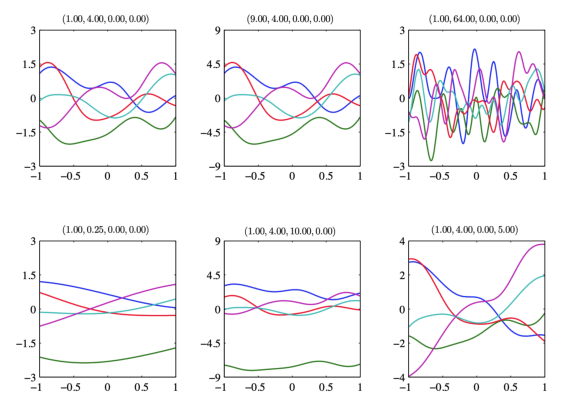

In [13]:
# 图6.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.5.png')
plt.axis('off')
ax.imshow(d)

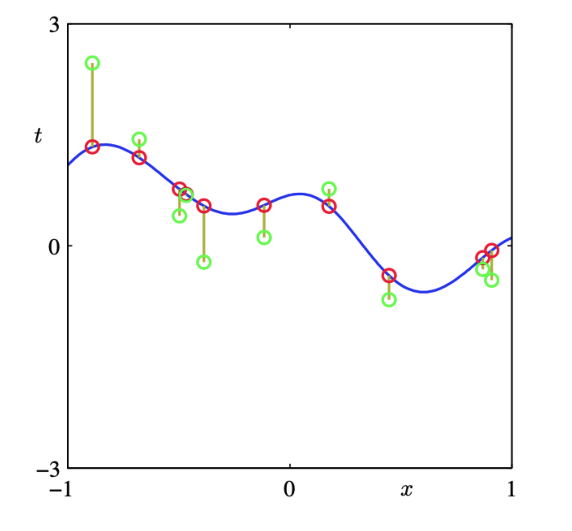

In [14]:
# 图6.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.6.png')
plt.axis('off')
ax.imshow(d)

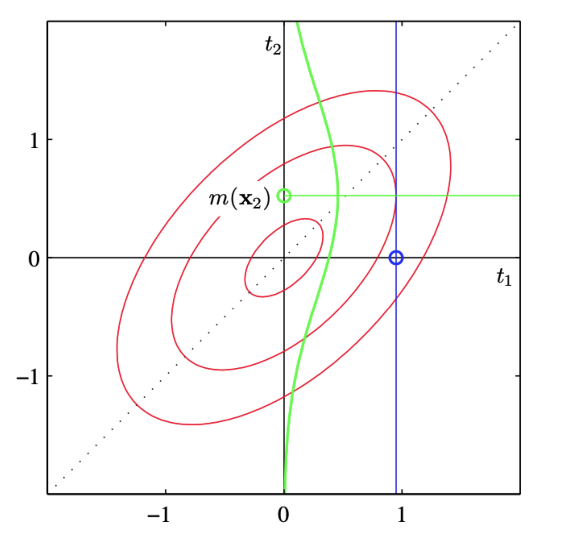

In [15]:
# 图6.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.7.png')
plt.axis('off')
ax.imshow(d)

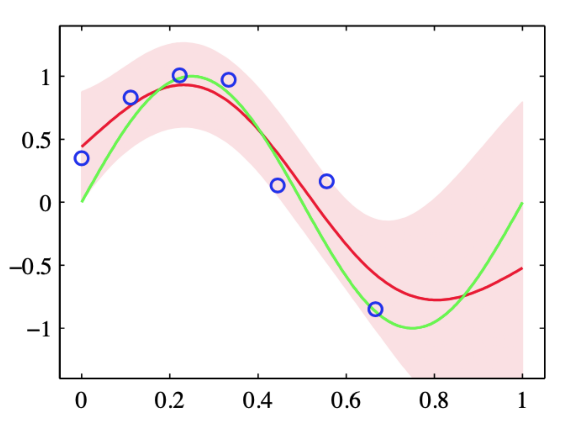

In [16]:
# 图6.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.8.png')
plt.axis('off')
ax.imshow(d)

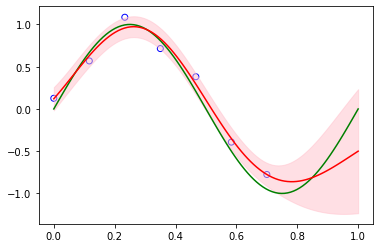

In [7]:
# 例子
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

model = GaussianProcessRegressor(kernel=RBF(np.array([1., 15.])), beta=100)
model.fit(x_train, y_train)

y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.show()

## 6.4.3 学习超参数

高斯过程模型的预测部分依赖于协方差函数的选择。实际运用中，比起拟合协方差矩阵，我们更喜欢使用一组带参数的函数，然后根据数据推断出它们的值。这些参数控制了相关性的长度缩放以及噪声的精度等等，对应于标准参数模型的超参数。
学习超参数的方法基于计算似然函数$ p(t|\theta) $，其中$ \theta $表示高斯过程模型的超参数。最简单的方法是通过最大化似然函数的方法进行$ \theta $的点估计。由于$ \theta $表示回归问题的一组超参数，因此这可以看成类似于线性回归模型的第二类最大似然步骤。可以使用高效的基于梯度的最优化算法（如共轭梯度法）来最大化对数似然函数（Fletcher, 1987; Nocedal and Wright, 1999; Bishop and Nabney, 2008）。
使用多元高斯分布的标准形式，高斯过程模型的形式为
$ \ln p(t|\theta) = -\frac{1}{2}\ln\vert C_N \vert - \frac{1}{2}t^TC_N^{-1}t - \frac{N}{2}\ln(2\pi) \tag{6.69} $
的对数似然函数很容易计算。对于非线性最优化，我们也需要对数似然函数关于参数向量$ \theta $的梯度。我们假设计算$ C_N $的导数就是比较简单的，本章中讨论的协方差函数的情形。使用式（C.21）给出的$ C_N^{-1} $的导数，以及式（C.22）给出的$ \ln\vert C_N \vert $的结果，得到
$ \frac{\partial}{\partial \theta_i}\ln p(t|\theta) = -\frac{1}{2} Tr\left(C_N^{-1}\frac{\partial C_N}{\partial\theta_i}\right) + \frac{1}{2}t^TC_N^{-1}\frac{\partial C_N}{\partial\theta_i}C_N^{-1}t \tag{6.70} $
由于$ \ln p(t|\theta) $通常是一个非凸函数，因此它由多个极大值点。
引入一个$ \theta $上的先验分布然后使用基于梯度的方法最大化对数后验是很容易的。在一个纯粹的贝叶斯方法中，我们需要计算$ \theta $的边缘概率可以通过乘以先验概率$ p(\theta) $和似然函数$ p(t|\theta) $来加权。然而，通常精确的积分或求和是不可行的。我们必须进行近似。
高斯过程回归模型给出的预测分布的均值和方差是输入向量$ x $的函数。然而，我们已经假定由参数$ \beta $控制的附加噪声对预测方差的贡献是常数。对于一些被称为异方差（heteroscedastic）的问题，噪声方差本身也依赖于$ x $。为了对这种问题进行建模，我们可以对高斯过程框架进行推广，引入第二个高斯过程来表示$ \beta $对于输入$ x $的依赖性（Goldberg et al., 1998）。由于$ \beta $是一个方差，因此是非负的，所以我们使用高斯过程来对$ \ln\beta(x) $进行建模。



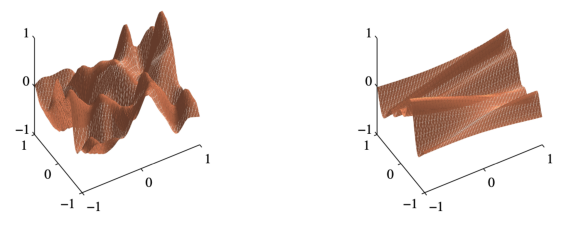

In [17]:
# 图6.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.9.png')
plt.axis('off')
ax.imshow(d)

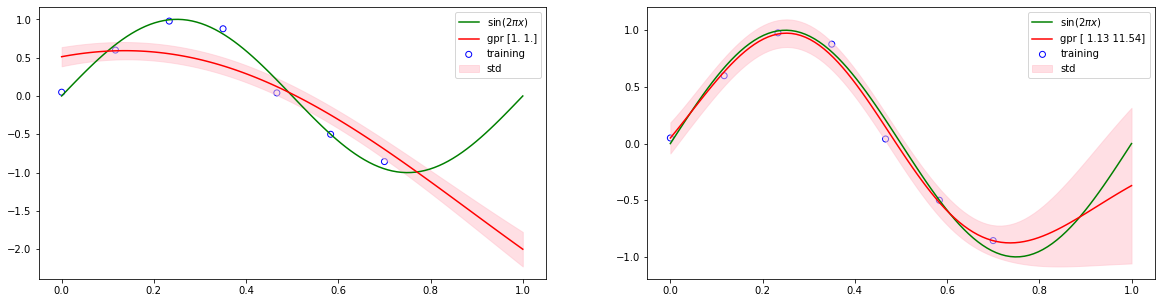

In [8]:
# 例子
x_train, y_train = create_toy_data(sinusoidal, n=7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model = GaussianProcessRegressor(kernel=RBF(np.array([1., 1.])), beta=100)
model.fit(x_train, y_train)
y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr {}".format(model.kernel.params))
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.legend()

plt.subplot(1, 2, 2)
model.fit(x_train, y_train, iter_max=100)
y, y_std = model.predict(x, with_error=True)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr {}".format(np.round(model.kernel.params, 2)))
plt.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")
plt.legend()
plt.show()

## 6.4.4 自动相关性确认

在前一节里，我们看到最大似然方法如何被用于确定高斯过程中的长度缩放参数的值。通过为每个输入变量整合一个单独的参数，这种方法可以很有用地推广（Rasmussen and Williams, 2006）。正如我们将看到的那样，这样做的结果是，通过最大似然方法进行的参数最优化，能够将不同输入的相对重要性从数据中推断出来。这是高斯过程中的自动相关性确定（automatic relevance detemination）或ARD的一个例子。它起源于神经网络的框架（MacKay, 1994; Neal, 1996）。这种方法倾向于选择合适的输入的机理在7.2.2节讨论。
考虑二维输入空间$ x = (x_1,x_2) $，有一个形式为：
$$
k\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\theta_{0} \exp \left\{-\frac{1}{2} \sum_{i=1}^{2} \eta_{i}\left(x_{i}-x_{i}^{\prime}\right)^{2}\right\}
\tag{6.71} $$
的核函数。图6.9给出了两个不同的精度参数$ \eta_i $的设定下，$ y(x) $的先验概率分布。
 
图 6.9 来自高斯过程的ARD先验的样本，其中核函数由式（6.71）给出。左图对应于$ \eta_1 = \eta_2 = 1 $，右 图对应于$ \eta_1 = 1, \eta_2 = 0.01 $。
我们看到，随着特定的$ \eta_i $的减小，函数逐渐对对应的输入变量$ x_i $不敏感。通过使用最大似然法按照数据集调整这些参数，它可以检测到对于预测分布几乎没有影响的输入变量，因为对应的ηi会很小。这在实际应用中很有用，因为它使得这些输入可以被遗弃。图6.10使用一个具有三个输入$ x_1, x_2, x_3 $的简单人造数据集来说明ARD（Nabney, 2002）。
 
图 6.10 高斯过程的自动相关性检测的例子。数据集是人工生成的数据集，由三个输入$ x_1, x_2, x_3 $。曲线表示对应的超参数的值与最优化边缘似然函数时的迭代次数的关系，红色表示$ \eta_1 $，绿色表示$ \eta_2 $，蓝色表示$ \eta_3 $。细节在正文中给出。注意垂直轴的对数标度。
目标变量$ t $是通过一个高斯分布中采样$ 100 $个$ x_1 $，计算函数$ \sin(2\pi x_1) $，然后加上添加上高斯噪声生成的。$ x_2 $的值通过复制对应的$ x_1 $然后添加噪声的方式获得，$ x_3 $的值从一个独立的高斯分布中采样的。因此，$ x_1 $很好地预测了$ t $，$ x_2 $对$ t $的预测的噪声更大，$ x_3 $与$ t $之间只有偶然的相关性。一个带有ARD参数$ \eta_1, \eta_2, \eta_3 $的高斯过程的边缘似然函数使用放缩的共轭梯度算法进行最优化。从图6.10中，我们看到$ \eta_1 $收敛到了一个相对较大的值，$ \eta_2 $收敛到了一个小得多的值，η3 变得非常小，表明$ x_3 $与预测$ t $无关。
ARD框架很容易整合到指数-二次核（6.63）中，得到下面形式的核函数，它对于一大类将高斯过程应用于回归问题的实际应用都很有帮助。
$$
k\left(\boldsymbol{x}_{n}, \boldsymbol{x}_{m}\right)=\theta_{0} \exp \left\{-\frac{1}{2} \sum_{i=1}^{D} \eta_{i}\left(x_{n i}-x_{m i}\right)^{2}\right\}+\theta_{2}+\theta_{3} \sum_{i=1}^{D} x_{n i} x_{m i}
\tag{6.72} $$
其中$ D $是输入空间的维度。



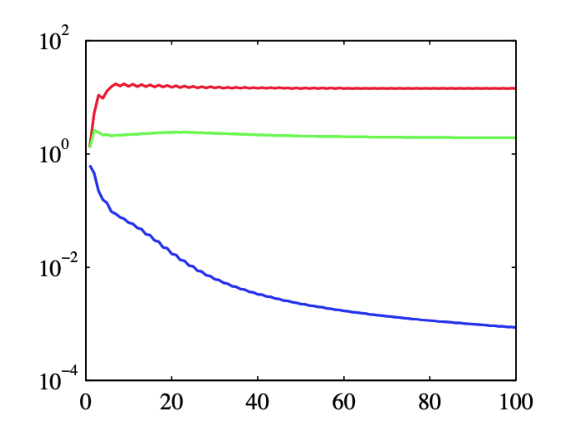

In [19]:
# 图6.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.10.png')
plt.axis('off')
ax.imshow(d)

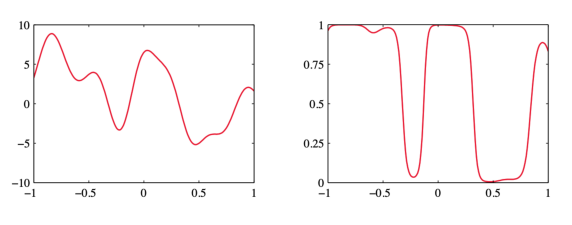

In [20]:
# 图6.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.11.png')
plt.axis('off')
ax.imshow(d)

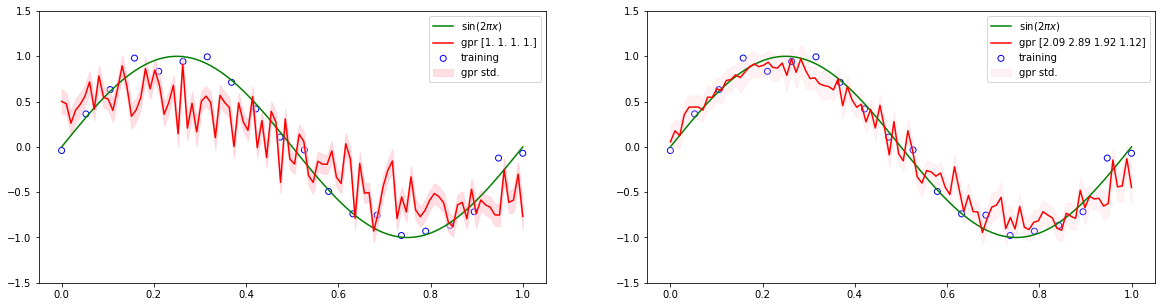

In [10]:
#例子
def create_toy_data_3d(func, n=10, std=1.):
    x0 = np.linspace(0, 1, n)
    x1 = x0 + np.random.normal(scale=std, size=n)
    x2 = np.random.normal(scale=std, size=n)
    t = func(x0) + np.random.normal(scale=std, size=n)
    return np.vstack((x0, x1, x2)).T, t
x_train, y_train = create_toy_data_3d(sinusoidal, n=20, std=0.1)
x0 = np.linspace(0, 1, 100)
x1 = x0 + np.random.normal(scale=0.1, size=100)
x2 = np.random.normal(scale=0.1, size=100)
x = np.vstack((x0, x1, x2)).T

model = GaussianProcessRegressor(kernel=RBF(np.array([1., 1., 1., 1.])), beta=100)
model.fit(x_train, y_train)
y, y_std = model.predict(x, with_error=True)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], y_train, facecolor="none", edgecolor="b", label="training")
plt.plot(x[:, 0], sinusoidal(x[:, 0]), color="g", label="$\sin(2\pi x)$")
plt.plot(x[:, 0], y, color="r", label="gpr {}".format(model.kernel.params))
plt.fill_between(x[:, 0], y - y_std, y + y_std, color="pink", alpha=0.5, label="gpr std.")
plt.legend()
plt.ylim(-1.5, 1.5)

model.fit(x_train, y_train, iter_max=100, learning_rate=0.001)
y, y_std = model.predict(x, with_error=True)
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], y_train, facecolor="none", edgecolor="b", label="training")
plt.plot(x[:, 0], sinusoidal(x[:, 0]), color="g", label="$\sin(2\pi x)$")
plt.plot(x[:, 0], y, color="r", label="gpr {}".format(np.round(model.kernel.params, 2)))
plt.fill_between(x[:, 0], y - y_std, y + y_std, color="pink", alpha=0.2, label="gpr std.")
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()

## 6.4.5 用于分类的高斯过程

在分类的概率方法中，我们的目标是在给定一组训练数据的情况下，对于一个新的输入向量，为目标变量的后验概率建模。这些概率一定位于区间$ (0, 1) $中，而一个高斯过程模型做出的预测位于整个实数轴上。然而，我们可以很容易地通过使用一个恰当的非线性激活函数，将高斯过程的输出进行变换来调整高斯过程，使其能够处理分类问题。
首先考虑一个二分类问题，它的目标变量为$ t \in {0, 1} $。如果我们定义函数$ a(x) $上的一个高斯过程，然后使用式（4.59）给出的logistic sigmoid函数$ y = \sigma(a) $进行变换，那么我们就得到了函数$ y(x) $上的一个非高斯随机过程，其中$ y \in (0, 1) $。图6.11说明了一维输入空间的情况，其中目标变量$ t $上的概率分布是伯努利分布
$ p(t|a) = \sigma(a)^t(1-\sigma(a))^{1-t} \tag{6.73} $
 
图 6.11 左图给出了在函数$ a(x) $上定义了一个高斯过程先验的样本，右图给出了使用logistic sigmoid对这 个样本进行变换得到的结果。
与之前一样，我们把训练集的输入记作$ x_1,...,x_N $，对应的观测目标变量为$ t = (t_1,...,t_N)^T $。我们还考虑一个单一的测试数据点$ x_{N+1} $，目标值为$ t_{N+1} $。我们的目标是确定预测分布$ p(t_{N+1}|t) $，其中我们没有显式地写出它对于输入变量的条件依赖。为了完成这个目标，我们引入向量$ a_{N+1} $上的高斯过程先验，它的分量为$ a(x_1),...,a(x_{N+1}) $。这反过来定义了$ t_{N+1} $上的一个非高斯过程。通过以训练数据$ N $为条件，我们得到了求解的预测分布。$ a_{N+1} $上的高斯过程先验的形式为
$ p(a_{N+1}) = \mathcal{N}(a_{N+1}|0, C_{N+1}) \tag{6.74} $
与回归的情形不同，协方差矩阵不再包含噪声项，因为我们假设所有的训练数据点都被正确标记。然而，由于数值计算的原因，更方便的做法是引入一个由参数$ v $控制的类似噪声的项，它确保了协方差矩阵是正定的。因此协方差矩阵$ C_{N+1} $的元素为
$ C(x_n,x_m) = k(x_n,x_m) _ v\delta_{nm} \tag{6.75} $
其中$ k(x_n,x_m) $是6.2节讨论的一个任意的半正定核函数，$ v $的值通常事先固定。我们会假定核函数$ k(x, x') $由参数向量$ \theta $控制，我们稍后会讨论如何从训练数据中学习到$ \theta $。
对于二分类问题，预测$ p(t_{N+1} = 1|t_N) $就足够了，因为$ p(t_{N+1}=0|t_N) $的值等于$ 1−p(t_{N+1}=1|t_N) $。求解的预测分布为
$ p(t_{N+1}=1|t_N) = \int p(t_{N+1}=1|a_{N+1})p(a_{N+1}|t_N)da_{N+1} \tag{6.76} $
其中$ p(t_{N+1}=1|a_{N+1}) = \sigma(a_{N+1}) $。
这个积分无法求出解析解，因此可以使用采样的方法近似(Neal, 1997)。我们还可以使用另一种基于一个解析的近似的方法。在4.5.2节，我们推导了logistic sigmoid函数与高斯 分布卷积的近似公式（4.153）。我们可以使用这个结果计算公式（6.76）中的积分，只要我们对后验概率分布$ p(a_{N+1}|t_N) $进行高斯近似。通常对后验概率进行高斯近似的理由是，根据中心极限定理，随着数据点数量的增加，真实的后验概率将会趋向于一个高斯分布。在高斯过程的情形中，变量的数量随着数据点数量的增多而增多，因此这个结果不能直接应用。然而，如果我们考虑增加落在x空间的固定区域中的数据点的数量，那么函数$ a(x) $中对应的不确定性就会减小，这就渐近地趋近于高斯分布(Williams and Barber, 1998)。
我们考虑三种不同的获得高斯近似的方法。一种方法基于变分推断（variational inference）（Gibbs and MacKay, 2000），并且使用了logistic sigmoid函数的局部变分界（10.144）。这使得sigmoid函数的乘积可以通过高斯的乘积近似，因此使得对$ a_N $的积分可以解析地计算。这种方法也产生了似然函数$ p(t_N|\theta) $的下界。通过使用softmax函数的高斯近似，高斯过程分类的变分法框架也可以扩展到多类$ (K > 2) $问题）Gibbs, 1997）。
第二种方法使用期望传播（expectation propagation）（Opper and Winther, 2000b; Minka, 2001b; Seeger, 2003）。正如我们将看到的那样，由于真实的后验概率是单峰的，期望传播方法可以给出很好的结果。



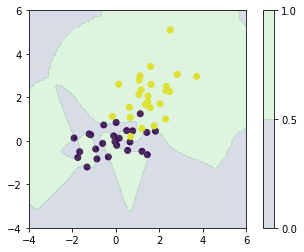

In [11]:
#例子
def create_toy_data():
    x0 = np.random.normal(size=50).reshape(-1, 2)
    x1 = np.random.normal(size=50).reshape(-1, 2) + 2.
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)[:, None]

x_train, y_train = create_toy_data()
x0, x1 = np.meshgrid(np.linspace(-4, 6, 100), np.linspace(-4, 6, 100))
x = np.array([x0, x1]).reshape(2, -1).T

model = GaussianProcessClassifier(RBF(np.array([1., 7., 7.])))
model.fit(x_train, y_train)
y = model.predict(x)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.ravel())
plt.contourf(x0, x1, y.reshape(100, 100), levels=np.linspace(0,1,3), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 6)
plt.ylim(-4, 6)
plt.gca().set_aspect('equal', adjustable='box')

## 6.4.6 拉普拉斯近似

分类的高斯过程的第三种方法是，现在我们要详细讨论的，基于拉普拉斯近似的。为了计算预测分布（6.76），我们寻找$ a_{N+1} $的后验分布的高斯近似，它由
$ \begin{eqnarray} p(a_{N+1}|t_N) &=& \int p(a_{N+1},a_N|t_N)da_N \ &=& \frac{1}{p(t_N)}\int p(a_{N+1},a_N)p(t_N|a_{N+1},a_N)da_N \ &=& \frac{1}{p(t_N)}\int p(a_{N+1}|a_N)p(a_N)p(t_N|a_N)da_N \ &=& \int p(a_{N+1}|a_N)p(a_N|t_N)da_N \tag{6.77} \end{eqnarray} $
其中，我们使用了$ p(t_N|a_{N+1},a_N) = p(t_N|a_N) $。条件分布$ p(a_{N+1}|a_N) $是通过式（6.66）和式（6.67）给出的高斯过程回归，来给出的：
$ p(a_{N+1}|a_N) = \mathcal{N}(a_{N+1}|k^TC_N^{-1}a_N,c-k^TC_N^{-1}k) \tag{6.78} $
于是，通过找到后验概率分布$ p(a_N|t_N) $的拉普拉斯近似，然后使用两个高斯分布卷积的标准结果，我们就可以计算式（6.77）中的积分。
先验概率$ p(a_N) $由一个均值为0，协方差矩阵为$ C_N $，数据项（假设数据点之间具有独立性）由
$ p(t_N|a_N) = \prod\limits_{n=1}^N\sigma(a_n)^{t_n}(1-\sigma(a_n))^{1-t_n} = \prod\limits_{n=1}^Ne^{a_nt_n}\sigma(-a_n) \tag{6.79} $
高斯过程给出。然后通过对$ p(a_N|t_N) $的对数进行泰勒展开，得到拉普拉斯近似。忽略掉一些可加的常数，这个概率对数为：
$ \begin{eqnarray} \Psi(a_N) &=& \ln p(a_N) + \ln p(t_N|a_N) \ &=& -\frac{1}{2}a_N^TC_N^{-1}a_N - \frac{N}{2}\ln(2\pi) - \frac{1}{2}\ln\vert C_N \vert + t_N^Ta_N \ & & -\sum\limits_{n=1}^N\ln (1+e^{a_n}) \tag{6.80} \end{eqnarray} $
首先我们需要找到后验概率分布的众数，这需要我们计算$ \Psi(a_N) $的梯度。这个梯度为
$ \nabla\Psi(a_N) = t_N - \sigma_N - C_N^{-1}a_N \tag{6.81} $
其中$ \sigma_N $是一个元素为$ \sigma(a_n) $的向量。寻找众数时，因为$ \sigma_N, a_N $的关系是非线性的，所以我们不能简单地令这个梯度等于0，因此我们需要使用基于Newton-Raphson方法的迭代的方法，它给出了一个迭代重加权最小平方（IRLS）算法。这需要求出$ \Psi(a_N) $的二阶导数，而这个二阶导数也需要进行拉普拉斯近似，结果为
$ \nabla\nabla\Psi(a_N) = -W_N - C_N^{-1} \tag{6.82} $
其中$ W_N $是一个对角矩阵，元素为$ \sigma(a_n)(1 − \sigma(a_n)) $，并且使用了式（4.88）给出的logistic sigmoid函数的导数的结果。注意，这些对角矩阵元素位于区间$ (0, 1) $，因此$ W_N $是一个正定矩阵。由于$ C_N $（以及它的逆矩阵）被构造为正定的，并且由于两个正定矩阵的和仍然是正定矩阵，因此我们看到Hessian矩阵$ A = −\nabla\nabla\Psi(a_N) $是正定的，因此后验概率分布$ p(a_N|t_N) $是对数凸函数，因此有一个唯一的众数，即全局最大值。然而，因为Hessian矩阵是$ a_N $的函数，所以后验概率不是高斯分布。
使用Newton-Raphson式（4.92），$ a_N $的迭代更新方程为
$ a_N^{new} = C_N(I + W_NC_N)^{-1}{t_N - \sigma_N + W_Na_N} \tag{6.83} $
这个方程反复迭代，直到收敛于众数（记作$ a_N^* $）。在这个众数位置，梯度$ \nabla\Psi(a_N) $为0，因此$ a_N^* $满足
$ a_N^* = C_N(t_N - \sigma_N) \tag{6.84} $
一旦我们找到了后验概率的众数$ a_N^* $，我们就可以计算Hessian矩阵，结果为
$ H = -\nabla\nabla\Psi(a_N) = W_N + C_N^{-1} \tag{6.85} $
其中$ W_N $的元素使用$ a_N^* $计算。这定义了我们对后验概率分布$ p(a_N|t_N) $的高斯近似，结果为
$ q(a_N) = \mathcal{N}(a_N|a_N^*,H^{-1}) \tag{6.86} $
我们现在可以将这个结果与式（6.78）结合，然后计算积分（6.77）。因为这对应于线性高斯模型，我们可以使用一般的结果（2.115）得到
$ \begin{eqnarray} \mathbb{E}[a_{N+1}|t_N] &=& k^T(t_N - \sigma_N) \tag{6.87}\\ var[a_{N+1}|t_N] &=& c - k^T(W_N^{-1} + C_N)^{-1}k \tag{6.88} \end{eqnarray} $
现在我们有一个$ p(a_{N+1}|t_N) $的高斯分布，我们可以使用式（4.153）的近似积分（6.76）。与4.5节的贝叶斯logistic回归模型相同，如果我们只对对应于$ p(t_{N+1}|t_N)=0.5 $的决策边界感兴趣，那么我们只需考虑均值，可以忽略方差的效果。
我们还需要确定协方差函数的参数$ \theta $。一种方法是最大化似然函数$ p(t_N|\theta) $，此时我们需要对数似然函数和它的梯度的表达式。如果必要的话，还可以加上正则化项，产生一个正则化的最大似然解。最大似然函数的定义为
$ p(t_N|\theta) = \int p(t_N|a_N)p(a_N|\theta)da_N \tag{6.89} $
这个积分没有解析解,所以我们需要再次使用拉普拉斯近似。使用式（4.135）的结果，我们得到了下面的对数似然函数的近似
$ \ln p(t_N|\theta) = \Psi(a_N^*) - \frac{1}{2}\ln \vert W_N + C_N^{-1} \vert + \frac{N}{2}\ln(2\pi) \tag{6.90} $
其中$ \Psi(a_N^) = \ln p（a_N^*|\theta) + \ln p(t_N|a_N^*) $。我们还需要计算$ \ln p(t_N|\theta) $关于参数向量$ \theta $梯度。注意，$ \theta $的改变会造成$ a_N^* $的改变，产生梯度中的附加项。因此，当我们对（6.90）关于$ \theta $求积分时，我们得到了两个项的集合，第一个集合产生于协方差矩阵$ C_N $对$ \theta $的依赖关系，第二个集合产生于$ a_N^* $对$ \theta $的依赖关系。
显式地依赖于$ \theta $的项可以使用式（6.80）以及式（C.21）（C.22）给出的结果得到：
$$
\begin{aligned}
\frac{\partial \ln p\left(\mathbf{t}_{N} \mid \boldsymbol{\theta}\right)}{\partial \theta_{j}}=& \frac{1}{2} \boldsymbol{a}_{N}^{* T} \boldsymbol{C}_{N}^{-1} \frac{\partial \boldsymbol{C}_{N}}{\partial \theta_{j}} \boldsymbol{C}_{N}^{-1} \boldsymbol{a}_{N}^{*} \\
&-\frac{1}{2} \operatorname{Tr}\left[\left(\boldsymbol{I}+\boldsymbol{C}_{N} \boldsymbol{W}_{N}\right)^{-1} \boldsymbol{W}_{N} \frac{\partial \boldsymbol{C}_{N}}{\partial \theta_{j}}\right]
\end{aligned}
\tag{6.91} $$
为了计算由于$ a_N^* $对$ \theta $的依赖产生的项，我们注意到我们已经构造了拉普拉斯近似，从而在$ a_N =a_N^* $处，$ \Psi(a_N) $的均值为0，所以$ \Psi(a_N^*) $对于梯度没有贡献。剩下的有贡献的项关于$ \theta $的分量$ \theta_j $的导数为
$$
\begin{aligned}
-\frac{1}{2} & \sum_{n=1}^{N} \frac{\partial \ln \left|\boldsymbol{W}_{N}+\boldsymbol{C}_{N}^{-1}\right|}{\partial a_{n}^{*}} \frac{\partial a_{n}^{*}}{\partial \theta_{j}} \\
&=-\frac{1}{2} \sum_{n=1}^{N}\left[\left(\boldsymbol{I}+\boldsymbol{C}_{N} \boldsymbol{W}_{N}\right)^{-1} \boldsymbol{C}_{N}\right]_{n n} \sigma_{n}^{*}\left(1-\sigma_{n}^{*}\right)\left(1-2 \sigma_{n}^{*}\right) \frac{\partial a_{n}^{*}}{\partial \theta_{j}}
\end{aligned}
\tag{6.92} $$
其中$ \sigma_n^* = \sigma(a_n^*) $，且又一次使用了式（C.22）给出的结果及$ W_N $的定义。我们可以将式（6.84）给出的关系关于$ \theta_j $求积分，得到$ a_N^ $关于$ \theta_j $的导数：
$$
\frac{\partial a_{n}^{*}}{\partial \theta_{j}}=\frac{\partial \boldsymbol{C}_{N}}{\partial \theta_{j}}\left(\mathbf{t}_{N}-\boldsymbol{\sigma}_{N}\right)-\boldsymbol{C}_{N} \boldsymbol{W}_{N} \frac{\partial a_{n}^{*}}{\partial \theta_{j}}
\tag{6.93} $$
整理，可得
$ \frac{\partial a_n^*}{\partial\theta_j} = (I + W_NC_N)^{-1}\frac{\partial C_N}{\partial\theta_j}(t_N - \sigma_N) \tag{6.94} $
结合公式（6.91）、（6.92）和（6.94），我们可以计算对数似然函数的梯度，然后使用标准非线性优化算法来确定$ \theta $的值。
我们可以使用人工生成的两类数据来说明拉普拉斯近似对于高斯过程的应用，如图6.12 所示。
 
图 6.5 使用高斯过程进行分类的说明。左图给出了数据点，以及来自真实概率分布的最优决策边界（绿色），还有来自高斯过程分类器的决策边界（黑色）。右图给出了蓝色类别和红色类别的预测后验概率分布，以及高斯过程决策边界。
很容易将拉普拉斯近似推广到涉及$ K > 2 $个类别的使用softmax激活函数的高斯过程 (Williams and Barber, 1998)。



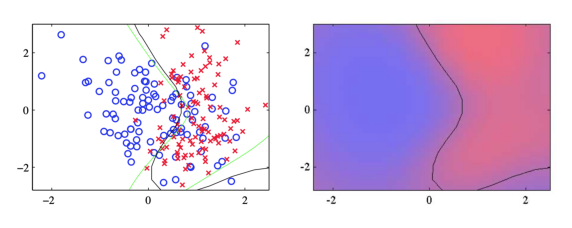

In [21]:
# 图6.12
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图6.12.png')
plt.axis('off')
ax.imshow(d)

## 6.4.7 与神经网络的联系

我们已经看到，神经网络可以表示的函数的范围由隐藏单元的数量$ M $控制，并且对于足够大的$ M $，一个两层神经网络可以以任意精度近似任意给定的函数。在最大似然的框架中，隐藏单元的数量需要有一定的限制（根据训练集的规模确定限制的程度），来避免过拟现象。然而，从贝叶斯的角度看，根据训练集的规模限制参数的数量几乎毫无意义。
在贝叶斯神经网络中，参数向量$ w $上的先验分布以及网络函数$ f(x,w) $产生了函数$ y(x) $上的先验概率分布，其中$ y $是网络输出向量。Neal(1996)已经证明，在极限$ M \to \infty $的情况下，对于$ w $的一大类先验分布，神经网络产生的函数的分布将会趋于高斯过程。然而，应该注意，在这种极限情况下，神经网络的输出变量会变为相互独立的。神经网络的优势之一是输出之间共享隐藏单元，因此它们可以互相“借统计优势”，即与每个隐含结点关联的权值被所有的输出变量影响，而不是只被它们中的某一个影响。这个性质在极限状态下的高斯过程中丢失了。
我们已经看到，高斯过程由它的协方差（核）函数确定。Williams(1998)给出了在两种具体的隐含单元激活函数（probit和高斯）下，协方差的显式形式。因为以0为中心的高斯权值先验破坏了权空间的平移不变性，所以这些核函数$ k(x, x') $是非静止的，即它们不能够表示为差$ x − x' $的函数。
通过直接对协方差函数计算，我们隐式地在权值的分布上进行了积分。如果权值先验由超参数控制，那么它们的值会确定函数的分布的长度标度，这可以通过研究图5.11给出的有限数量单元情形的例子进行理解。注意我们不能解析地对超参数进行积分，而是必须借助6.4节讨论的技术。

